## 1. Import Libraries

In [1]:
import os
import sys
import torch
import zipfile
import numpy as np # number python
from torch import nn # neural network (Conv2D - 2D Convolution Layer, Linear, Logistic)
from torch.nn import functional as F # activation function (ReLU, Sigmoid, SoftMax)
import torch.utils.data as td # tools to create & load dataset
import torchvision as tv # torchvision library for computer vision tasks
import pandas as pd # library for data analysis, manipulation -> data augmentation
from PIL import Image # library used for image handling
from matplotlib import pyplot as plt # plotting library to plot & visualize results
from sklearn.model_selection import train_test_split # function used to split training set

In [2]:
print(f'PyTorch Version: {torch.__version__}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(torch.cuda.get_device_name())

try: 
    print(f'CUDA Version: {torch.version.cuda}')
except:
    pass

PyTorch Version: 2.5.1+cu121
cuda
NVIDIA GeForce RTX 4070 Laptop GPU
CUDA Version: 12.1


## 2. Loading & Processing Dataset

### Dataset Location

In [3]:
dataset_root_dir = 'E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment 1/Dataset/'

### Data Processing 

In [4]:
class BirdDataset(td.Dataset): #td.Dataset is a class from td (torch.utils.data)

    # Constructor [Param: root file, train (training or testing dataset), download (online? if local x exist), target & label transform]

    # Custom Dataset uses different Constructor [Param up to dev]
    def __init__(self, root_dir, mode="train", image_size=(224,224) ):
        super().__init__() # Call Parent __init__ function, ensure proper inheritance. (Newed Python)
        self.image_size = image_size # Create new variable to store current self image_size 
        self.mode = mode

        # Loading .txt file (train.txt)
        # Change to Local File Path
        txt_path = os.path.join (root_dir, f'{mode}.txt')
        print("Text File:", txt_path)
        
        rows = []
        with open(txt_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().rsplit(" ", 1)  # Split only on the last space
                if len(parts) == 2:
                    file_path, label = parts
                    rows.append((file_path, int(label)))  # Safe conversion

        # Create DataFrame
        self.data = pd.DataFrame(rows, columns=["file_path", "class"])

        
        # Loading Dataset from Train Folder     
        self.images_dir = os.path.join(root_dir, "Train")
        ## Temp: Should Return "E:\Year 3 Sem 1\COS30082 Applied Machine Learning\Assignment 1\Dataset\Train"
    
    # Return No. of Data Images
    def __len__(self): # __len__ is a method with built-in len() function
        # print("Dataset Length:", len(self.data))
        return len(self.data)
    
    
    # Return Init Configuration
    def __repr__(self): 
        # __repr__ is a method to represent an object as a string. Images have x and y. Not using repr would result in the return of the memory location instead ( 0x10e104570)
        # Can represent other things too from a memory location
        
        return "BirdDataset: (mode='{}', image_size={})".format(self.mode, self.image_size)

    # Preparing the Images
    def __getitem__(self,idx):
        # Method automatically called, Allows class to behave like list or arrays
        # Used to call and "get" datasets in the form of image and label
        # Index 'idx'

        # Image Path
        img_path = os.path.join(self.images_dir, self.data.iloc[idx]['file_path'])
        ## Temp: Should Return "E:\Year 3 Sem 1\COS30082 Applied Machine Learning\Assignment 1\Dataset\Train" + "Specific Image Location"

        # Load Image
        img = Image.open(img_path)

        # Transformation
        transform = tv.transforms.Compose([
            # Resize the Image
            tv.transforms.Resize(self.image_size),

            # Convert it to Tensor
            tv.transforms.ToTensor(),

            # Normalize it to the standard range (1, -1)
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

            # C, H and W [Channel(Most common color channels), Height, Width]
            # 1st tuple -> Mean for (R,G,B), 2nd tuple -> S.T.D for (R,G,B)
        ])

        # Processed Image    
        x = transform(img)

        # Get Class Label from Train.txt file
        d = self.data.iloc[idx]['class']
        
        return x, d 
        
    def number_of_classes(self):
        return self.data['class'].max() + 1
    # Max is used to find the largest class number (Classes are represented by numbers)
    # Max + 1 because the index starts from 0 (To Compensate).
        

### View Modified Dataset

In [5]:
def show_img(image, ax=plt):
    # ax = axies object, plot area. ax=plt means default value for ax parameter

    image = image.to('cpu').numpy()
    # moves the tensor to the CPU because Matplotlib can only work with NumPy arrays that are on the CPU, not PyTorch tensors on the GPU.
    
    image = np.moveaxis(image, [0,1,2], [2,0,1])
    # Matplotlib expects different axes (H,W,C) compared to PyTorch (C,W,H)

    image = (image + 1) / 2
    # Unnormalize image

    image[image < 0] = 0
    image[image > 1] = 1

    i = ax.imshow(image)
    # matplotlib function that displays image

    ax.axis("off")

    return i

In [6]:
# Get sample from Training Set

# Create instance of dataset class (BirdDataset)
train_set = BirdDataset(dataset_root_dir)
x = train_set[10]

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment 1/Dataset/train.txt


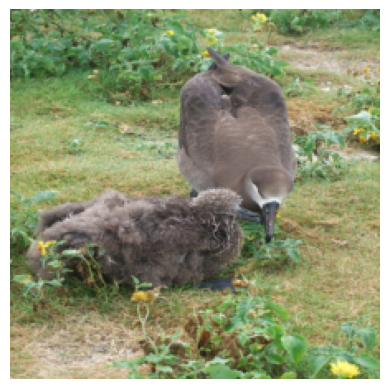

In [7]:
# Create Figure
plt.figure()
show_img(x[0])
# x is from the sample, and 0 is the index for image array x

### Loading Data

In [8]:
# Load Data thoruhg mini-batch size
train_loader = td.DataLoader(train_set, batch_size=16, shuffle = True, pin_memory = True)
# Use mini-batch size 16
# Shufffle so that the model does not predict based off data order
# pin_memory = True -> Speeds up transfer to the GPU

In [9]:
# How many mini-batches there are.
len(train_loader)

302

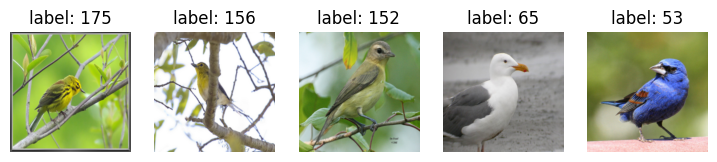

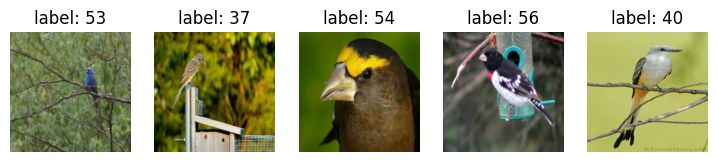

In [10]:
for _ in range(2):
   # _ is a throwaway variable
    fig, axes = plt.subplots(ncols=5, figsize=(9, 3))
    # Create Matplotlib figure with 5 subplots 
    for batch_idx, batch in enumerate(train_loader):
        if batch_idx == 5: 
            break
        show_img(batch[0][0], ax=axes[batch_idx])
        # batch[0] -> images tensor of the batch, batch[0][0] -> images tensor index (0 being the first index)
        # ax tells the image to plot on their respective subplot
        axes[batch_idx].set_title(f'label: {batch[1][0]}')
        # batch[1] -> represents the class label no.
        

Batch is a tuple(images, labels). Batch[0] represents Image Tensor and Batch[1] represents Labels Tensor

# 3. Validation Dataset

In [11]:
# from dataset import BirdDataset

In [12]:
val_ratio = 0.2          # 20% of training data used for validation
random_state = 20        # for reproducibility
stratify = True          # preserve class distribution

In [13]:
train_dir = 'E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment 1/Dataset/Train'

In [18]:
def make_dataset_df(root_dir, label_file):
    """
    Create a DataFrame containing image paths and class labels
    using a separate label text file.
    
    label_file format example:
        Black_footed_Albatross_0004_2731401028.jpg 0
        Black_footed_Albatross_0006_2665243472.jpg 0
    """
    data = []  

    # Open and read each line from the txt file
    with open(label_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            img_name, label = line.split()
            img_path = os.path.join(root_dir, img_name)
            
            # Store the data
            data.append({
                'file_path': img_path,
                'class': int(label)  
            })

    # Return as DataFrame
    return pd.DataFrame(data)


# Example usage
train_dir = r"E:\Year 3 Sem 1\COS30082 Applied Machine Learning\Assignment 1\Dataset\train"
label_file = r"E:\Year 3 Sem 1\COS30082 Applied Machine Learning\Assignment 1\Dataset\train.txt"

df = make_dataset_df(train_dir, label_file)
print(f"Total training images found: {len(df)}")
print(df.head())

Total training images found: 4829
                                           file_path  class
0  E:\Year 3 Sem 1\COS30082 Applied Machine Learn...      0
1  E:\Year 3 Sem 1\COS30082 Applied Machine Learn...      0
2  E:\Year 3 Sem 1\COS30082 Applied Machine Learn...      0
3  E:\Year 3 Sem 1\COS30082 Applied Machine Learn...      0
4  E:\Year 3 Sem 1\COS30082 Applied Machine Learn...      0


In [19]:
def split_train_val(df, target_column="class", val_ratio=0.2, random_state=20, stratify=True):
    """
    Split dataset into training and validation sets while preserving class distribution.
    """
    stratify_col = df[target_column] if stratify else None

    X_train, X_val, y_train, y_val = train_test_split(
        df['file_path'],
        df[target_column],
        test_size=val_ratio,
        random_state=random_state,
        stratify=stratify_col
    )

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_train_val(df, val_ratio=val_ratio, random_state=random_state, stratify=stratify)
print(f"Training images: {len(X_train)} | Validation images: {len(X_val)}")

Training images: 3863 | Validation images: 966


In [20]:
train_txt_path = os.path.join(dataset_root_dir, "train_split.txt")
val_txt_path = os.path.join(dataset_root_dir, "val_split.txt")

X_train.to_csv(train_txt_path, index=False, header=False)
X_val.to_csv(val_txt_path, index=False, header=False)

print(f"Saved train split to: {train_txt_path}")
print(f"Saved val split to:   {val_txt_path}")

Saved train split to: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment 1/Dataset/train_split.txt
Saved val split to:   E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment 1/Dataset/val_split.txt


In [23]:
train_set = BirdDataset(dataset_root_dir, mode="train_split")
val_set = BirdDataset(dataset_root_dir, mode="val_split")

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment 1/Dataset/train_split.txt


ValueError: invalid literal for int() with base 10: '1\\Dataset\\train\\Indigo_Bunting_0024_2539293425.jpg'

In [ ]:
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)
val_loader = td.DataLoader(val_set, batch_size=16, pin_memory=True)

print("✅ DataLoaders ready.")
print(f"Train batches: {len(train_loader)} | Validation batches: {len(val_loader)}")

# Classifier Class

In [ ]:
import torch.nn as nn

In [ ]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

## 4. Transfer Learning 1 - Convolutional Neural Network

### Load Pre-trained VGG Model

In [ ]:
from torchvision.models import VGG16_BN_Weights, vgg16_bn

In [ ]:
# vgg = tv.models.vgg16_bn(pretrained = True)

vgg = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)

In [ ]:
vgg

In [ ]:
# List all the parameters in the transferred model
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

# features.0.weight torch.Size([64, 3, 3, 3]) True
# Outputs: 64 Filters, 3 input channels, 3 x 3 kernel size 

### Fine-Tuning & Freezing

In [ ]:
class VGG16Transfer(Classifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        f = self.features(x).view(x.shape[0], -1)       
        y = self.classifier(f)
        return y

In [ ]:
num_classes = train_set.number_of_classes()

In [ ]:
vgg16transfer = VGG16(num_classes)

In [ ]:
vgg16transfer

In [ ]:
for name, param in vgg16transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

In [ ]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}


In [ ]:
import nntools as nt

lr = 1e-3
net = VGG16(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

In [ ]:
!cat birdclass1/config.txt

In [ ]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    # training loss
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    # evaluation loss
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(('training loss', 'evaluation loss'))
    
    # training accuracy
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                 label="training accuracy")
    # evaluation accuracy
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                 label="evaluation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(('training accuracy', 'evaluation accuracy'), loc='lower right')
    
    plt.tight_layout()
    fig.canvas.draw()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## 5. Transfer Learning 2 - ResNet18